## 1. Import Required Libraries

In [30]:
# Import dynasir components
from dynasir import DataContainer, Model, process_data_from_owid

# Import visualization and evaluation
from dynasir import visualize_results, evaluate_forecast

# Standard libraries
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data

We'll use COVID-19 data from Our World in Data (OWID). The data includes confirmed cases, deaths, and population.

In [31]:
# Load global COVID-19 data
raw_data = process_data_from_owid(iso_code="OWID_WRL")

print(f"Data loaded: {len(raw_data)} days")
print(f"Date range: {raw_data.index.min()} to {raw_data.index.max()}")
print(f"\nColumns: {list(raw_data.columns)}")
print(f"\nFirst few rows:")
raw_data.head()

Data loaded: 2137 days
Date range: 2020-01-04 00:00:00 to 2025-11-09 00:00:00

Columns: ['C', 'D', 'N']

First few rows:


,C,D,N
date,,,
2020-01-04,3.0,0.0,8.021407e+09
2020-01-05,2.0,3.0,8.021407e+09
2020-01-06,5.0,3.0,8.021407e+09
2020-01-07,5.0,3.0,8.021407e+09
2020-01-08,6.0,3.0,8.021407e+09


## 3. Create DataContainer

The `DataContainer` handles all data preprocessing:
- 7-day moving average smoothing
- SIRD compartment calculation (S, I, R, D)
- Rate calculation (α, β, γ)
- Logit transformation for VAR modeling

In [32]:
# Create container with 7-day smoothing window
container = DataContainer(raw_data, window=7)

print("DataContainer created successfully!")
print(f"\nProcessed data shape: {container.data.shape}")
print(f"\nAvailable columns:")
print(container.data.columns.tolist())

# Display sample of processed data
container.data.tail(10)

2025-11-28 04:47:36,014 - root - INFO - No vaccination data detected. Using SIRD model.


DataContainer created successfully!

Processed data shape: (2130, 20)

Available columns:
['C', 'D', 'N', 'R', 'I', 'S', 'A', 'dC', 'dA', 'dS', 'dI', 'dR', 'dD', 'alpha', 'beta', 'gamma', 'R0', 'logit_alpha', 'logit_beta', 'logit_gamma']


,C,D,N,R,I,S,A,dC,dA,dS,dI,dR,dD,alpha,beta,gamma,R0,logit_alpha,logit_beta,logit_gamma
2025-10-31,7.788062e+08,7.102397e+06,8.021407e+09,7.716481e+08,55780.571428,7.242601e+09,7.242657e+09,3312.571429,-4701.857142,-3312.571428,-1389.285714,4690.285714,11.571429,0.059386,0.084085,0.000207,0.704529,-2.762471,-2.388101,-8.480434
2025-11-01,7.788095e+08,7.102408e+06,8.021407e+09,7.716527e+08,54391.285714,7.242598e+09,7.242652e+09,3312.571429,-4701.857143,-3312.571429,-1389.285714,4690.285714,11.571429,0.060903,0.086232,0.000213,0.704529,-2.735635,-2.360532,-8.455207
2025-11-02,7.788129e+08,7.102420e+06,8.021407e+09,7.716574e+08,53002.000000,7.242594e+09,7.242647e+09,2920.571429,-4318.857142,-2920.571428,-1398.285714,4308.285714,10.571429,0.055103,0.081285,0.000199,0.676242,-2.841863,-2.425010,-8.519731
2025-11-03,7.788158e+08,7.102431e+06,8.021407e+09,7.716617e+08,51603.714286,7.242591e+09,7.242643e+09,2794.428571,-4228.714286,-2794.428572,-1434.285714,4218.714286,10.000000,0.054152,0.081752,0.000194,0.660827,-2.860285,-2.418775,-8.548570
2025-11-04,7.788186e+08,7.102441e+06,8.021407e+09,7.716660e+08,50169.428571,7.242589e+09,7.242639e+09,2794.428571,-4228.714286,-2794.428571,-1434.285714,4218.714286,10.000000,0.055700,0.084089,0.000199,0.660827,-2.830460,-2.388039,-8.520377
2025-11-05,7.788214e+08,7.102451e+06,8.021407e+09,7.716702e+08,48735.142857,7.242586e+09,7.242635e+09,2794.428571,-4228.714286,-2794.428572,-1434.285714,4218.714286,10.000000,0.057339,0.086564,0.000205,0.660827,-2.799717,-2.356328,-8.491365
2025-11-06,7.788242e+08,7.102461e+06,8.021407e+09,7.716744e+08,47300.857143,7.242583e+09,7.242630e+09,2794.428571,-4228.714286,-2794.428572,-1434.285714,4218.714286,10.000000,0.059078,0.089189,0.000211,0.660827,-2.767999,-2.323578,-8.461487
2025-11-07,7.788270e+08,7.102471e+06,8.021407e+09,7.716786e+08,45866.571429,7.242580e+09,7.242626e+09,2794.428571,-4228.714285,-2794.428571,-1434.285714,4218.714286,10.000000,0.060926,0.091978,0.000218,0.660826,-2.735242,-2.289720,-8.430689
2025-11-08,7.788298e+08,7.102481e+06,8.021407e+09,7.716828e+08,44432.285714,7.242577e+09,7.242622e+09,2794.428571,-4228.714286,-2794.428572,-1434.285714,4218.714286,10.000000,0.062892,0.094947,0.000225,0.660826,-2.701376,-2.254674,-8.398911
2025-11-09,7.788325e+08,7.102491e+06,8.021407e+09,7.716871e+08,42998.000000,7.242575e+09,7.242618e+09,2794.428571,-4228.714286,-2794.428572,-1434.285714,4218.714286,10.000000,0.062892,0.094947,0.000225,0.660826,-2.701376,-2.254674,-8.398911


## 4. Create and Fit SIRD Model

We'll create a model for a specific time period and fit a VAR model to the logit-transformed rates.

In [33]:
# Define training period
start_date = "2020-03-01"
stop_date = "2020-12-31"

# Create model
model = Model(container, start=start_date, stop=stop_date)

print(f"Model created for period: {start_date} to {stop_date}")
print(f"Has vaccination: {model.has_vaccination}")

# Create and fit VAR model
model.create_model()
model.fit_model(max_lag=10, ic="aic")

print("\nModel fitted successfully!")
print(f"Optimal lag order: {model.var_forecasting.logit_ratios_model_fitted.k_ar}")

2025-11-28 04:47:36,079 - root - INFO - Model initialized with 3 rates (SIRD mode)
2025-11-28 04:47:36,080 - root - INFO - VAR forecasting initialized with 3 rates: SIRD (3-rate)
2025-11-28 04:47:36,080 - root - INFO - VAR forecasting initialized with 3 rates: SIRD (3-rate)


Model created for period: 2020-03-01 to 2020-12-31
Has vaccination: False

Model fitted successfully!
Optimal lag order: 9


## 5. Generate Forecasts

Forecast 30 days ahead with confidence intervals.

In [34]:
# Forecast 30 steps ahead
forecast_steps = 30
model.forecast(steps=forecast_steps)

print(f"Forecast generated for {forecast_steps} days")
print(f"\nForecasting interval: {model.forecasting_interval[0]} to {model.forecasting_interval[-1]}")

# Show sample forecast for infection rate (alpha)
print("\nSample alpha (infection rate) forecast:")
print(f"Lower bound: {model.var_forecasting.forecasting_box['alpha']['lower'].head().tolist()}")
print(f"Point forecast: {model.var_forecasting.forecasting_box['alpha']['point'].head().tolist()}")
print(f"Upper bound: {model.var_forecasting.forecasting_box['alpha']['upper'].head().tolist()}")

2025-11-28 04:47:36,122 - root - INFO - Simulation initialized without vaccination (SIRD mode)


Forecast generated for 30 days

Forecasting interval: 2021-01-01 00:00:00 to 2021-01-30 00:00:00

Sample alpha (infection rate) forecast:
Lower bound: [0.06773704634489805, 0.06493896874041115, 0.06401979918937199, 0.06380379672047844, 0.06338744501566639]
Point forecast: [0.06484243883612996, 0.06093640665558744, 0.059301623955249974, 0.05852331403862451, 0.05789120934368496]
Upper bound: [0.07075109480257973, 0.06918506668578196, 0.06908579449740167, 0.06952554585757574, 0.06936707635010865]


## 6. Run Monte Carlo Simulations

Run 27 simulation scenarios (3³ combinations of lower/point/upper for α, β, γ).

In [35]:
# Run simulations (use n_jobs=None for auto parallel execution)
model.run_simulations(n_jobs=1)  # Use 1 for sequential, None for parallel

print("Simulations completed!")
print(f"\nSimulation scenarios: 27 (3³)")
print(f"Available scenarios: {list(model.simulation.keys())}")

2025-11-28 04:47:36,137 - root - INFO - Running 27 SIRD scenarios (3^3)


Simulations completed!

Simulation scenarios: 27 (3³)
Available scenarios: ['lower', 'point', 'upper']


## 7. Generate Results

Aggregate simulation results with central tendency measures.

In [36]:
# Generate final results
model.generate_result()

print("Results generated!")
print(f"\nAvailable compartments: {list(model.results.keys())}")
print(f"\nConfirmed cases (C) results shape: {model.results.C.shape}")

# Show sample results
print("\nSample confirmed cases forecast:")
print(model.results.C[['mean', 'median', 'gmean', 'hmean']].head())

Results generated!

Available compartments: ['A', 'C', 'S', 'I', 'R', 'D']

Confirmed cases (C) results shape: (30, 31)

Sample confirmed cases forecast:
                    mean        median         gmean         hmean
2021-01-01  8.121568e+07  8.121568e+07  8.121568e+07  8.121568e+07
2021-01-02  8.179860e+07  8.179826e+07  8.179858e+07  8.179858e+07
2021-01-03  8.235364e+07  8.235255e+07  8.235359e+07  8.235357e+07
2021-01-04  8.289493e+07  8.289269e+07  8.289481e+07  8.289477e+07
2021-01-05  8.342700e+07  8.342322e+07  8.342678e+07  8.342668e+07


## 8. Visualize Results

Visualize forecasts for different compartments.

Confirmed Cases Forecast:


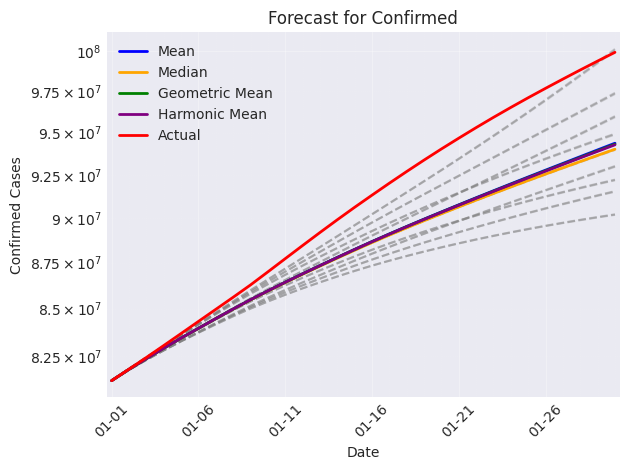

In [37]:
# Prepare testing data for comparison
testing_data = container.data.loc[model.forecasting_interval]

# Visualize confirmed cases
print("Confirmed Cases Forecast:")
model.visualize_results("C", testing_data=testing_data, log_response=True)

Deaths Forecast:


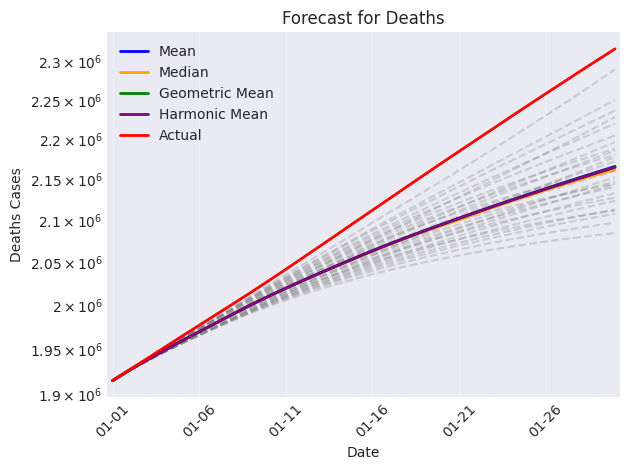

In [38]:
# Visualize deaths
print("Deaths Forecast:")
model.visualize_results("D", testing_data=testing_data, log_response=True)

Infected Population Forecast:


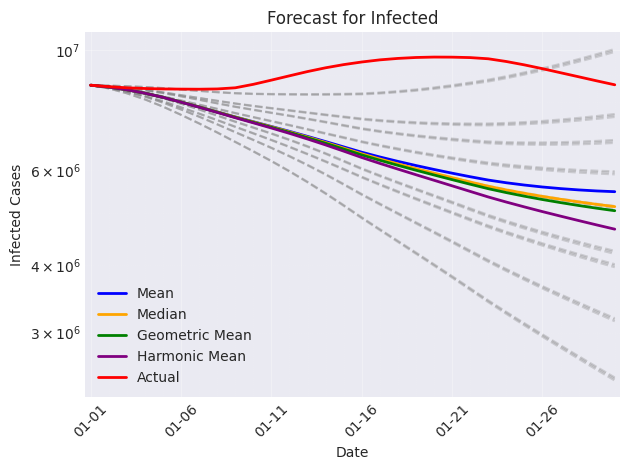

In [39]:
# Visualize infected population
print("Infected Population Forecast:")
model.visualize_results("I", testing_data=testing_data, log_response=True)

## 9. Evaluate Model Performance

Calculate evaluation metrics (MAE, MSE, RMSE, MAPE, SMAPE).

In [40]:
# Evaluate forecast performance
evaluation = model.evaluate_forecast(
    testing_data,
    compartment_codes=("C", "D", "I")
)

# Display evaluation metrics
print("Model Evaluation Metrics:\n")
for compartment in ["C", "D", "I"]:
    print(f"\n{compartment} (Mean forecast):")
    metrics = evaluation[compartment]["mean"]
    print(f"  MAE:   {metrics['mae']:.2f}")
    print(f"  RMSE:  {metrics['rmse']:.2f}")
    print(f"  MAPE:  {metrics['mape']:.2f}%")
    print(f"  SMAPE: {metrics['smape']:.2f}%")

Model Evaluation Metrics:


C (Mean forecast):
  MAE:   2557760.64
  RMSE:  3181436.53
  MAPE:  2.70%
  SMAPE: 1.38%

D (Mean forecast):
  MAE:   56751.99
  RMSE:  74327.10
  MAPE:  2.57%
  SMAPE: 1.31%

I (Mean forecast):
  MAE:   2293528.58
  RMSE:  2698497.32
  MAPE:  24.71%
  SMAPE: 14.90%


## 10. Summary

**Key Takeaways**:

1. **SIRD Model**: Models time-varying infection (α), recovery (β), and mortality (γ) rates
2. **VAR Forecasting**: Uses Vector Autoregression on logit-transformed rates
3. **Monte Carlo**: 27 scenarios capture uncertainty across confidence levels
4. **Evaluation**: Multiple metrics assess forecast accuracy
5. **Visualization**: Professional plots with central tendencies and actual data

**Next Steps**:
- Try different time periods or countries
- Experiment with different lag orders
- Use parallel simulations for faster execution
- Explore the SIRDV model with vaccination data